In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
#creating SQL connection
conn = sqlite3.connect('../Data/pet_care_industry.db')
c = conn.cursor()

#function to close connection
def close_c_conn():
    c.close()
    conn.close()

# Exploratory Data Analysis (EDA): Competitor Concentration

In [114]:
#joining business and neighborhood tables from SQL database
businesses_neighborhoods = pd.read_sql_query('''SELECT
    Name,
    Rating,
    Review_Count,
    stores_and_services.ZipCode,
    Neighborhood,
    Borough
    FROM stores_and_services
    LEFT JOIN neighborhoods
    ON stores_and_services.ZipCode = neighborhoods.ZipCode''', conn)

businesses_neighborhoods = businesses_neighborhoods.set_index('Name')
businesses_neighborhoods

,Rating,Review_Count,ZipCode,Neighborhood,Borough
Name,,,,,
NYC Pet,2.5,15,11211,Greenpoint,Brooklyn
NYC Pet,5.0,8,11211,Greenpoint,Brooklyn
Petland Discounts,3.5,6,11237,Bushwick and Williamsburg,Brooklyn
Park slope Pet,5.0,10,11215,Northwest Brooklyn,Brooklyn
Petland Discounts,3.0,19,11216,Central Brooklyn,Brooklyn
Pet Central,3.5,6,10128,Upper East Side,Manhattan
Petland Discounts,2.5,9,11206,Bushwick and Williamsburg,Brooklyn
Pet Valu,3.0,14,7002,None,None
"Slope Pet Food Supplies, Inc",5.0,8,11215,Northwest Brooklyn,Brooklyn


In [184]:
businesses_neighborhoods.describe()

,Rating,Review_Count,ZipCode
count,1502.000000,1502.000000,1502.000000
mean,4.036618,30.506658,10028.626498
std,0.945724,39.018705,2366.409873
min,1.000000,1.000000,6830.000000
25%,3.500000,7.000000,10003.000000
50%,4.500000,17.000000,10128.000000
75%,5.000000,39.000000,11217.000000
max,5.000000,384.000000,80301.000000


In [185]:
concentration = businesses_neighborhoods.groupby('Name').size().reset_index(name='Stores')
concentration = concentration.sort_values(by='Stores', ascending=False)
concentration['Share %'] = concentration['Stores'] / concentration['Stores'].sum() * 100
concentration['Concentration Index'] = concentration['Share %'].cumsum()
concentration = concentration.reset_index()
concentration = concentration.drop('index', axis=1)
concentration.index = concentration.index + 1
concentration.head(8)

,Name,Stores,Share %,Concentration Index
1,Petco,46,3.062583,3.062583
2,Petland Discounts,43,2.862850,5.925433
3,PetSmart,26,1.731025,7.656458
4,Banfield Pet Hospital,18,1.198402,8.854860
5,Pet Valu,14,0.932091,9.786951
6,Pet Supplies Plus,13,0.865513,10.652463
7,Pet Central,9,0.599201,11.251664
8,Biscuits & Bath,9,0.599201,11.850866


In [186]:
HHI_industry = sum(concentration['Share %']**2)
HHI_industry

30.921930989485492

In [187]:
n_concentration = businesses_neighborhoods.groupby('Neighborhood').size().reset_index(name='Stores')
n_concentration = n_concentration.sort_values(by='Stores', ascending=False)
n_concentration['Share %'] = n_concentration['Stores'] / n_concentration['Stores'].sum() * 100
n_concentration['Concentration Index'] = n_concentration['Share %'].cumsum()
n_concentration = n_concentration.reset_index()
n_concentration = n_concentration.drop('index', axis=1)
n_concentration.index = n_concentration.index + 1
n_concentration.head(8)

,Neighborhood,Stores,Share %,Concentration Index
1,Northwest Brooklyn,94,9.055877,9.055877
2,Chelsea and Clinton,79,7.610790,16.666667
3,Northwest Queens,73,7.032755,23.699422
4,Upper East Side,72,6.936416,30.635838
5,Upper West Side,65,6.262042,36.897881
6,Lower East Side,47,4.527938,41.425819
7,Greenpoint,44,4.238921,45.664740
8,Greenwich Village and Soho,44,4.238921,49.903661


In [188]:
HHI_neighborhood = sum(n_concentration['Share %']**2)
HHI_neighborhood

447.5035361466582

# Exploratory Data Analysis (EDA): Market Size

In [233]:
#initialize dog growth table with unique list of neighborhoods
key = 'Neighborhood'
dog_growth = pd.read_sql_query('SELECT DISTINCT {} FROM neighborhoods'.format(key), conn)
dog_growth = dog_growth.set_index(key)
print(dog_growth.shape)
dog_growth.head()

(42, 0)


""
Neighborhood
Chelsea and Clinton
Lower East Side
Lower Manhattan
Gramercy Park and Murray Hill
Greenwich Village and Soho


In [234]:
#function to select dogs by neighborhoods for a given year
def get_dogs_by_year(year):
    return pd.read_sql_query("""SELECT {}, LicenseIssuedYear AS CY{}
                                FROM dogs
                                LEFT JOIN neighborhoods
                                ON dogs.ZipCode = neighborhoods.ZipCode
                                WHERE LicenseIssuedYear <= {}
                                AND LicenseExpiredYear >= {};""".format(key, year, year, year), conn)

for i in range(2014, 2023):
    dog_growth = pd.merge(dog_growth, get_dogs_by_year(i).groupby(key).count(), on=key, how='left')
    
dog_growth = dog_growth.fillna(0).astype(int)
dog_growth

,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022
Neighborhood,,,,,,,,,
Chelsea and Clinton,113,2312,5995,4163,904,448,310,157,2
Lower East Side,89,1817,4770,3273,657,327,184,92,1
Lower Manhattan,35,711,1779,1217,261,121,80,38,0
Gramercy Park and Murray Hill,73,1486,3912,2723,583,280,192,95,2
Greenwich Village and Soho,59,1155,3077,2180,485,244,173,87,1
Upper East Side,126,2689,7265,5089,976,444,298,140,3
Upper West Side,177,2807,7679,5484,1121,505,316,140,5
Central Harlem,37,885,2268,1532,276,123,80,46,3
East Harlem,25,779,2096,1422,248,127,88,48,3


In [235]:
total_market = dog_growth.sum()
total_market

CY2014      1879
CY2015     44522
CY2016    120031
CY2017     82505
CY2018     13451
CY2019      6007
CY2020      3884
CY2021      1940
CY2022        52
dtype: int64

In [236]:
dog_growth['5Y CAGR 2014-2019'] = (((dog_growth['CY2019'] / dog_growth['CY2014']) ** (1/5)) - 1) * 100
dog_growth = dog_growth.sort_values(by=['5Y CAGR 2014-2019'], ascending=False)
dog_growth = dog_growth.replace(np.inf, np.nan)
dog_growth = dog_growth.dropna(subset=['5Y CAGR 2014-2019'])
dog_growth

,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019
Neighborhood,,,,,,,,,,
Southwest Queens,26,1078,2929,1969,294,135,91,49,1,39.018335
East Harlem,25,779,2096,1422,248,127,88,48,3,38.411681
Flatbush,13,741,1906,1236,168,55,31,16,1,33.439335
High Bridge and Morrisania,11,512,1302,824,92,46,30,13,0,33.129110
Greenwich Village and Soho,59,1155,3077,2180,485,244,173,87,1,32.833484
Chelsea and Clinton,113,2312,5995,4163,904,448,310,157,2,31.716419
West Queens,53,1694,4452,2999,465,209,135,65,1,31.575213
Gramercy Park and Murray Hill,73,1486,3912,2723,583,280,192,95,2,30.847984
Borough Park,30,915,2540,1770,282,112,82,45,0,30.142562


In [237]:
dog_growth['Share 2016'] = dog_growth['CY2019'] / total_market['CY2019'] * 100
dog_growth = dog_growth.sort_values(by=['Share 2016'], ascending=False)
dog_growth

,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019,Share 2016
Neighborhood,,,,,,,,,,,
Upper West Side,177,2807,7679,5484,1121,505,316,140,5,23.328549,8.406859
Northwest Brooklyn,139,2591,6728,4736,998,494,334,151,6,28.867211,8.223739
Chelsea and Clinton,113,2312,5995,4163,904,448,310,157,2,31.716419,7.457966
Upper East Side,126,2689,7265,5089,976,444,298,140,3,28.647836,7.391377
Lower East Side,89,1817,4770,3273,657,327,184,92,1,29.727351,5.443649
Gramercy Park and Murray Hill,73,1486,3912,2723,583,280,192,95,2,30.847984,4.661229
Greenwich Village and Soho,59,1155,3077,2180,485,244,173,87,1,32.833484,4.061928
West Queens,53,1694,4452,2999,465,209,135,65,1,31.575213,3.479274
South Shore,63,1803,5567,4025,454,175,104,52,1,22.670320,2.913268


In [249]:
bcg_matrix = pd.merge(dog_growth, n_concentration, on=key, how='left')
bcg_matrix = bcg_matrix.drop(columns=['Share %', 'Concentration Index'])
bcg_matrix['Dogs per Store'] = bcg_matrix['CY2016'] / bcg_matrix['Stores']
bcg_matrix['Dogs per Store'] = bcg_matrix['Dogs per Store'].astype(int)
bcg_matrix

,Neighborhood,CY2014,CY2015,CY2016,CY2017,CY2018,CY2019,CY2020,CY2021,CY2022,5Y CAGR 2014-2019,Share 2016,Stores,Dogs per Store
0,Upper West Side,177,2807,7679,5484,1121,505,316,140,5,23.328549,8.406859,65,118
1,Northwest Brooklyn,139,2591,6728,4736,998,494,334,151,6,28.867211,8.223739,94,71
2,Chelsea and Clinton,113,2312,5995,4163,904,448,310,157,2,31.716419,7.457966,79,75
3,Upper East Side,126,2689,7265,5089,976,444,298,140,3,28.647836,7.391377,72,100
4,Lower East Side,89,1817,4770,3273,657,327,184,92,1,29.727351,5.443649,47,101
5,Gramercy Park and Murray Hill,73,1486,3912,2723,583,280,192,95,2,30.847984,4.661229,42,93
6,Greenwich Village and Soho,59,1155,3077,2180,485,244,173,87,1,32.833484,4.061928,44,69
7,West Queens,53,1694,4452,2999,465,209,135,65,1,31.575213,3.479274,23,193
8,South Shore,63,1803,5567,4025,454,175,104,52,1,22.670320,2.913268,16,347
9,Northwest Queens,59,1264,3402,2337,388,173,117,64,1,24.004892,2.879973,73,46


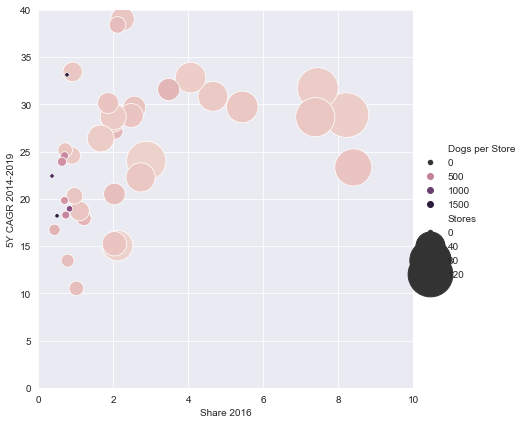

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.color_palette("RdYlGn", 10))
ax = sns.relplot(x='Share 2016',
            y='5Y CAGR 2014-2019',
            hue='Dogs per Store',
            size='Stores',
            sizes=(20,2000),
            data=bcg_matrix,
            height=6);
sns.set_style('darkgrid')
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 40))

In [267]:
#close connection
close_c_conn()